# 1. Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.model_selection import LeaveOneOut
from skimage.feature import hog

# 2. Load vectors and labels of dataset

Load data from numpy array and randomly select one example for visualization.

In [2]:
X=np.load('vectors.npy')
Y=np.load('labels.npy')

(-0.5, 167.5, 191.5, -0.5)

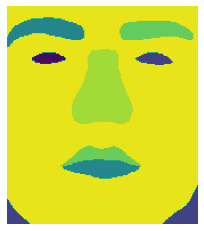

In [3]:
idx=np.random.randint(100)
exp=X[idx].reshape(192,168)
plt.imshow(exp)
plt.axis('off')

(-0.5, 167.5, 191.5, -0.5)

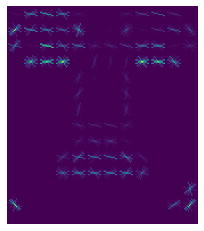

In [4]:
exp=X[idx].reshape(192,168)
fd,hog_img=hog(exp,orientations=8,cells_per_block=(4,4),pixels_per_cell=(14,14),visualize=True)
plt.imshow(hog_img)
plt.axis('off')

In [5]:
print(fd.shape)

(11520,)


In [6]:
feature=[]
for i in tqdm(range(len(X))):
    exp=X[i].reshape(192,168)
    fd,hog_img=hog(exp,orientations=8,cells_per_block=(4,4),pixels_per_cell=(14,14),visualize=True)
    feature.append(fd)
    
feature=np.array(feature)

100%|███████████████████████████████████████| 2388/2388 [00:56<00:00, 41.99it/s]


# 3. Model selection

* Use K-Fold cross-validation to estimate performance of model.
* We choose `k=10` for every experiments.
* K-Nearest Neighbors with `k=3`,`k=5`,`k=7`, Support Vector Machine, Logistic Regression.

In [7]:
def LOOExperiment(model,X,Y):
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    total_acc=[]

    for train_index, test_index in loo.split(X):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        pca=PCA(0.95)
        scaler=StandardScaler()
        
        x_pca=pca.fit_transform(x_train)
        x_norm=scaler.fit_transform(x_pca)
        
        x_test_pca=pca.transform(x_test)
        x_test_norm=scaler.transform(x_test_pca)
        
        model.fit(x_norm,y_train)
        y_pred=model.predict(x_test_norm)
        total_acc.append(1-np.mean(y_test!=y_pred))

    return np.mean(total_acc)

In [7]:
def KFoldExperiment(model,X,Y):
    kf = KFold(n_splits=10)
    kf.get_n_splits(Y)
    total_acc=[]

    for train_index, test_index in kf.split(Y):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        pca=PCA(0.95)
        scaler=StandardScaler()
        
        x_pca=pca.fit_transform(x_train)
        x_norm=scaler.fit_transform(x_pca)
        
        x_test_pca=pca.transform(x_test)
        x_test_norm=scaler.transform(x_test_pca)
        
        model.fit(x_norm,y_train)
        y_pred=model.predict(x_test_norm)
        total_acc.append(1-np.mean(y_test!=y_pred))
    return np.mean(total_acc)

In [8]:
clf_svm=SVC(kernel='linear')
clf_log=LogisticRegression()
clf_knn=KNeighborsClassifier(3)

In [9]:
model=[clf_log,clf_svm,clf_knn]
mean_acc=[]

for i in tqdm(range(len(model))):
    result=KFoldExperiment(model[i],feature,Y)
    mean_acc.append(result)

100%|████████████████████████████████████████████| 3/3 [09:06<00:00, 182.17s/it]


In [10]:
name_model=['Logistic Regression','SVM','KNN']

df_result=pd.DataFrame(data=[mean_acc],columns=name_model)
df_result

,Logistic Regression,SVM,KNN
0,0.994972,0.99497,0.801104


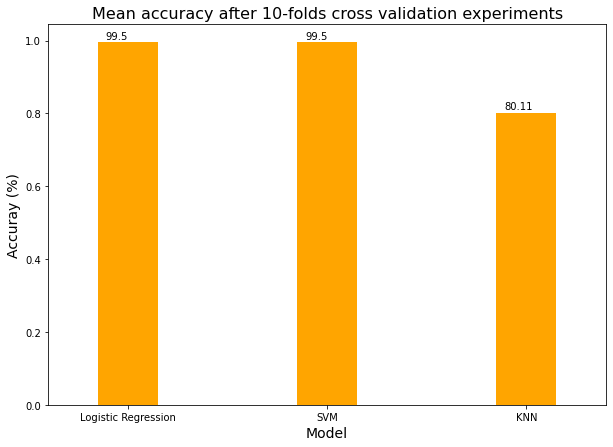

In [11]:
ax=df_result.loc[0].plot(width=0.3,kind='bar',figsize=(10,7),color='orange')
plt.title('Mean accuracy after 10-folds cross validation experiments',size=16)
plt.ylabel('Accuray (%)',size=14)
plt.xlabel('Model',size=14)
plt.xticks(rotation=0, horizontalalignment="center")
totals = []

for i in ax.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()+0.04, i.get_height()+0.01, \
            str(round((i.get_height()*100),2)), fontsize=10,
                color='black')
plt.savefig('crop_yales.png')